# Data Preparation

The following code is adapted to the CHAOS-MRT2 dataset found [here](https://chaos.grand-challenge.org/Data/).

The libraries needed to run this code are available here. Please refer to the README.md for installation.

Let's start with importing the required libraries

In [8]:
# Importing libraries 
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import random

## Normalization of the data



We first define our input_folder and output_folder

In [18]:
# Input and output folders
def create_folder_normalized():
    input_folder = 'CHAOS-MRT2'  
    output_folder = 'CHAOS-MRT2-NORMALIZED' 

    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)  
    return input_folder,output_folder

Then we normalize the source images :
$$
\text{Normalized Image} = \frac{\text{Image} - \min(\text{Image})}{\max(\text{Image}) - \min(\text{Image})}
$$




In [19]:
def normalize_image(image_array):
    return (image_array - np.min(image_array)) / (np.max(image_array) - np.min(image_array))

Then, we convert mask images into integer classes, facilitating easier data handling for tasks like segmentation : 
$$
\text{mask\_array\_int}(x, y, z) = 
\begin{cases} 
0, & \text{if } \text{mask\_array}(x, y, z) = 0 \quad \text{(Background)} \\
1, & \text{if } \text{mask\_array}(x, y, z) = 80 \quad \text{(Class 1)} \\
2, & \text{if } \text{mask\_array}(x, y, z) = 160 \quad \text{(Class 2)} \\
3, & \text{if } \text{mask\_array}(x, y, z) = 240 \quad \text{(Class 3)} \\
4, & \text{if } \text{mask\_array}(x, y, z) = 255 \quad \text{(Class 4)} \\
\end{cases}
$$

In [ ]:

# Function to convert masks to integer classes
def convert_mask(mask_array):
    mask_array_int = np.zeros_like(mask_array, dtype=np.uint8)
    mask_array_int[mask_array == 0] = 0  # Background
    mask_array_int[mask_array == 80] = 1  # Class 1
    mask_array_int[mask_array == 160] = 2  # Class 2
    mask_array_int[mask_array == 240] = 3  # Class 3
    mask_array_int[mask_array == 255] = 4  # Class 4
    return mask_array_int

Finally, we compute these functions considering the specificities of the dataset

In [21]:
def folder_normalized(input_folder, output_folder):
    # Iterate through all files in the folder
    for filename in os.listdir(input_folder):
        if filename.endswith('-src.nii.gz'):  # Source file (image)
            # Load the source file
            src_path = os.path.join(input_folder, filename)
            src_img = nib.load(src_path)
            src_array = src_img.get_fdata()

            # Normalize the image (consider if this step is necessary)
            src_array_norm = normalize_image(src_array).astype(np.float32)

            # Save the normalized image
            output_path = os.path.join(output_folder, filename)
            new_src_img = nib.Nifti1Image(src_array_norm, affine=src_img.affine)
            nib.save(new_src_img, output_path)
            print(f"Normalized source image saved: {output_path}")

        elif filename.endswith('-mask.nii.gz'):  # Mask file
            # Load the mask file
            mask_path = os.path.join(input_folder, filename)
            mask_img = nib.load(mask_path)
            mask_array = mask_img.get_fdata()

            # Convert masks to integer classes
            mask_array_int = convert_mask(mask_array)

            # Save the converted mask
            output_path = os.path.join(output_folder, filename)
            new_mask_img = nib.Nifti1Image(mask_array_int, affine=mask_img.affine)
            nib.save(new_mask_img, output_path)
            print(f"Converted mask saved: {output_path}")


## Conversion to 2D files

The problem with nii.gz files is that they are very large as 3D model input so we convert them into 2D files in order to train the model.


We first define our input_folder and output_folder

In [22]:
def create_folder_2D():    
    # Input and output folders
    input_folder = 'CHAOS-MRT2-NORMALIZED' 
    output_folder = 'CHAOS-MRT2-2D-NORMALIZED' 

    # Create the output folder if it does not exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    return input_folder,output_folder

Then cut the nni.gz files along the z axis and we keep in memory the number, the type of the file and the number of the cut and save the files.

In [23]:
def folder_normalized_2D(input_folder,output_folder):
    # Iterate through all files in the folder
    for filename in os.listdir(input_folder):
        if filename.endswith('.nii.gz'):
            # Load the 3D file
            file_path = os.path.join(input_folder, filename)
            img = nib.load(file_path)
            img_data = img.get_fdata()
            affine = img.affine

            # Slice the image into 2D slices along the z-axis
            num_slices = img_data.shape[2]  # Dimension of the z-axis
            base_filename = filename.replace('.nii.gz', '')  # Base name without the extension

            for i in range(num_slices):
                # Extract the 2D slice
                slice_2d = img_data[:, :, i]

                # Create a new NIfTI object for the 2D slice
                slice_img = nib.Nifti1Image(slice_2d, affine=affine)

                # Define the output name
                output_filename = f"{base_filename}-z{i}.nii.gz"
                output_path = os.path.join(output_folder, output_filename)

                # Save the 2D slice
                nib.save(slice_img, output_path)


There is the global function to prepare the data

In [24]:
def global_preparation():
    input_folder,output_folder_1=create_folder_normalized()
    folder_normalized(input_folder,output_folder_1)
    output_folder_1,output_folder_2=create_folder_2D()
    folder_normalized_2D(output_folder_1,output_folder_2)

In [ ]:
global_preparation()

## Visualization

Let's visualize a random file

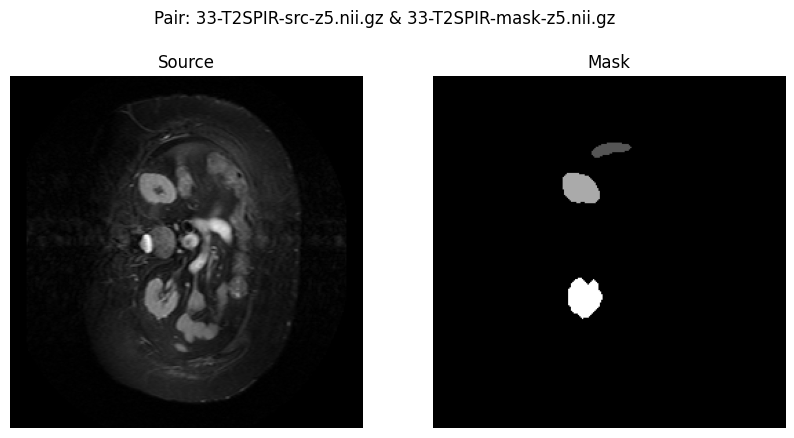

In [14]:

def display_random_pair(data_dir):
    """
    Display a random source-mask pair (source on the left, mask on the right) based on file naming.
    
    :param data_dir: Path to the directory containing .nii.gz files
                     (files must follow the structure XX-T2SPIR-Y-zPP.nii.gz).
    """
    # Get all files in the directory
    files = os.listdir(data_dir)
    
    # Filter files into source (Y = src) and mask (Y = mask)
    src_files = [f for f in files if "-src-" in f]
    mask_files = [f for f in files if "-mask-" in f]
    
    if not src_files or not mask_files:
        print("No source or mask files found in the directory.")
        return

    # Choose a random source file
    random_src_file = random.choice(src_files)
    
    # Extract the base identifier (XX) and slice number (zPP) from the source file
    base_name = random_src_file.split("-src-")[0]  # Extract XX
    slice_number = random_src_file.split("-src-")[-1].split(".nii.gz")[0]  # Extract zPP (e.g., "z1")

    # Find the corresponding mask file
    corresponding_mask_file = None
    for mask_file in mask_files:
        if mask_file.startswith(f"{base_name}-mask-"):
            # Extract the slice number from the mask file
            mask_slice_number = mask_file.split("-mask-")[-1].split(".nii.gz")[0]
            # Compare the slice numbers (remove the 'z' prefix and compare as integers)
            if int(mask_slice_number[1:]) == int(slice_number[1:]):
                corresponding_mask_file = mask_file
                break
    
    if not corresponding_mask_file:
        print(f"No corresponding mask found for: {random_src_file}")
        return
    
    # Load the source and mask data
    src_path = os.path.join(data_dir, random_src_file)
    mask_path = os.path.join(data_dir, corresponding_mask_file)
    src_data = nib.load(src_path).get_fdata()
    mask_data = nib.load(mask_path).get_fdata()
    
    # Handle potential 3D files (take the first slice if 3D)
    if src_data.ndim == 3:
        src_data = src_data[:, :, 0]
    if mask_data.ndim == 3:
        mask_data = mask_data[:, :, 0]
    
    # Display the source and mask images side by side
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(src_data, cmap="gray")
    plt.title("Source")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(mask_data, cmap="gray")
    plt.title("Mask")
    plt.axis("off")
    
    plt.suptitle(f"Pair: {random_src_file} & {corresponding_mask_file}")
    plt.show()
display_random_pair('CHAOS-MRT2-2D-NORMALIZED')